For reference, this is roughly the workflow we are recreating in the SDK.



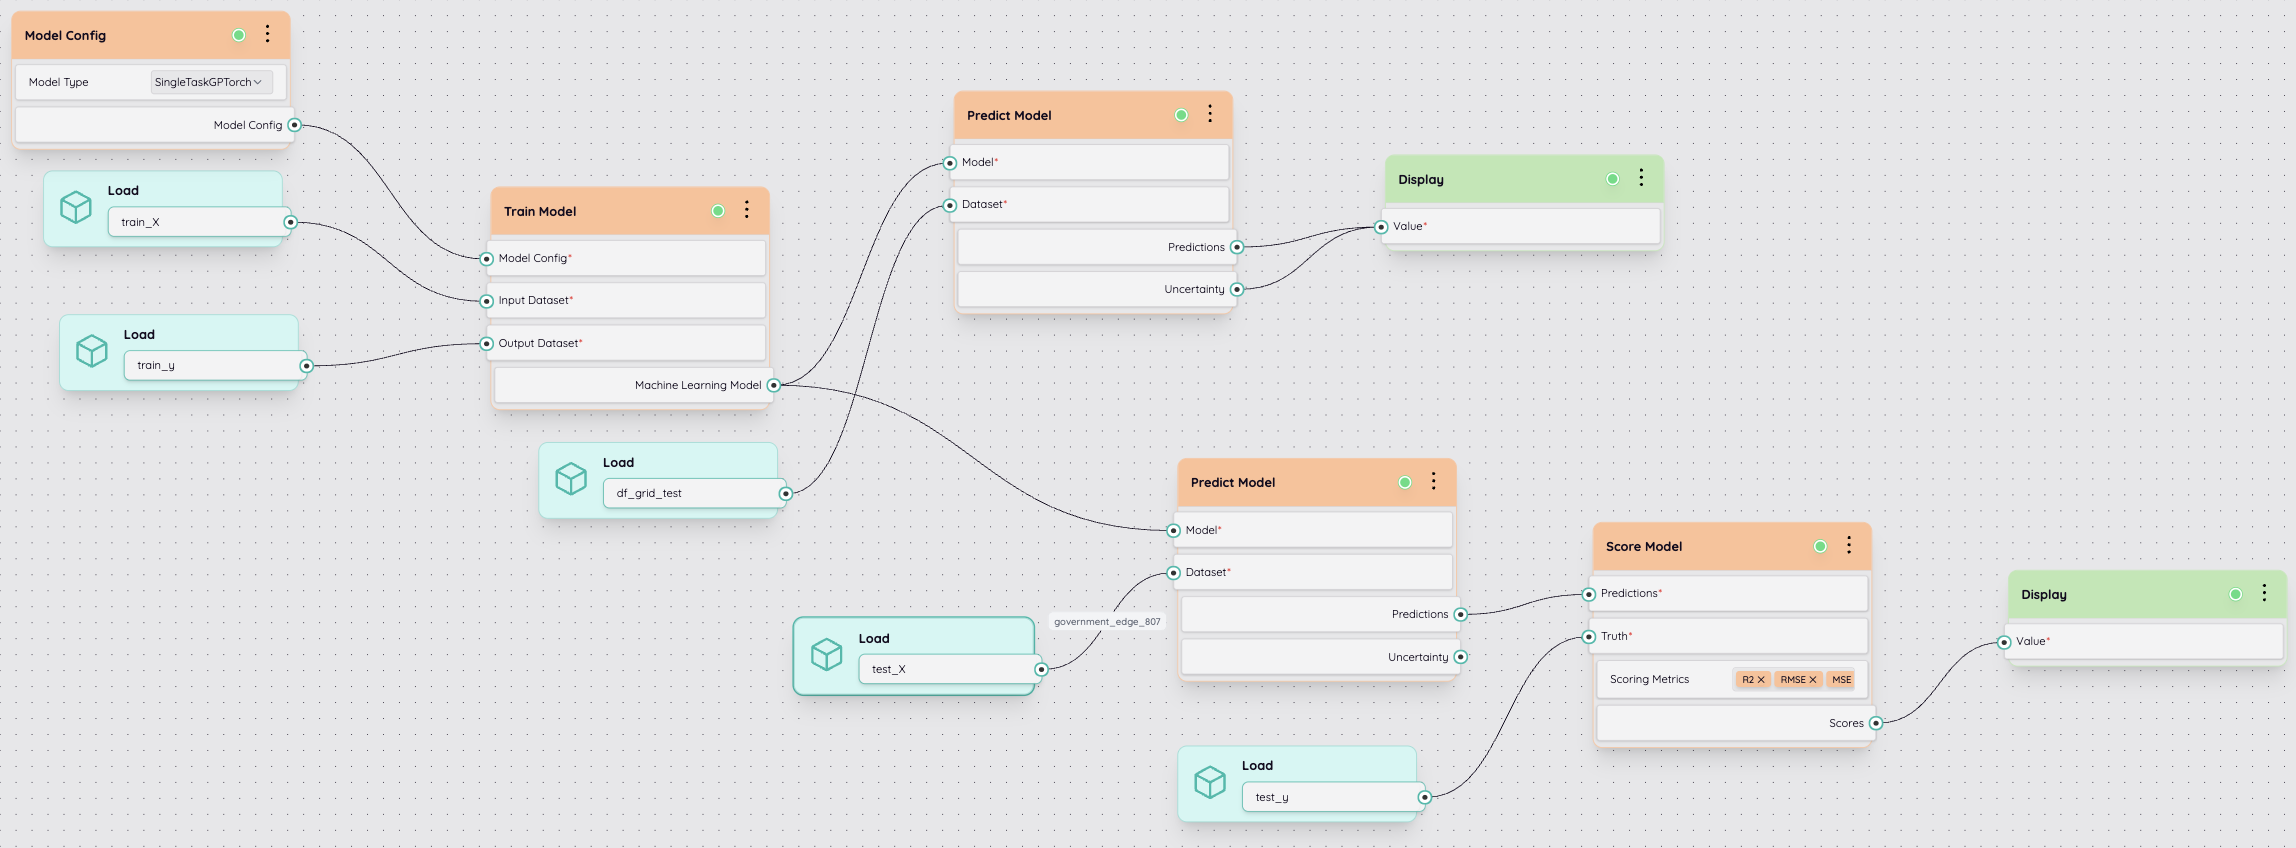

In [ ]:
# Install the basic library
%pip install uncertainty-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Neater, usable

#Importing libraries
import os
from dotenv import load_dotenv
from uncertainty_engine.client import Client, Environment
from uncertainty_engine.graph import Graph
from uncertainty_engine.nodes.basic import Add
from uncertainty_engine.nodes.base import Node
from uncertainty_engine_types import ResourceID
from uncertainty_engine.nodes.workflow import Workflow

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from pprint import pprint
from io import BytesIO
from io import StringIO
import requests


In [ ]:
os.environ["UE_USERNAME"] = "USERNAME FROM ACCOUNT"
os.environ["UE_PASSWORD"] = "PASSWORD FROM ACCOUNT"

client = Client()
client.authenticate()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-80106074.py:2: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(r"/content/drive/Shareddrives/digiLab Shared Drive/5. Bus Dev & Sales/Clients/Universities/University of Manchester/UoM - LIBRTI - 001/tL translation to SDK/results copy.csv",sep="\s+")


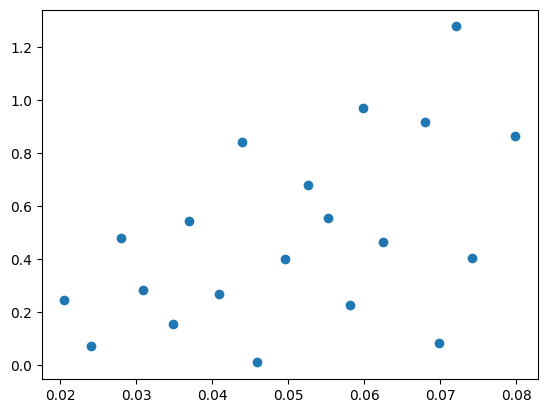

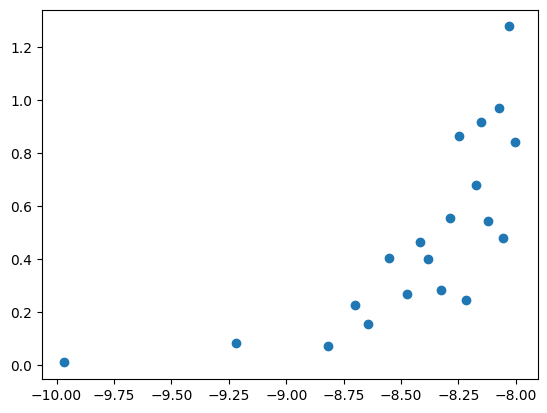

In [ ]:
# Read the training data from galaxy workflows
df = pd.read_csv(r"RESULTS_CSV PATH",sep="\s+")

df_input = pd.DataFrame({
    "solubility": df["solubility"][:20],
    "logdiffusivity":np.log10(df["diffusivity"][:20]),
    "p_out_grad":df["p_out_grad"][:20]

})

# Plot the relationship between indevidual inputs and outputs
plt.scatter(df_input["solubility"],df_input["p_out_grad"])
plt.show()

plt.scatter(df_input["logdiffusivity"],df_input["p_out_grad"])
plt.show()

In [ ]:
# Define features and target
X = df_input[["solubility", "logdiffusivity"]]
y = df_input["p_out_grad"]

# Split into train (75%) and test (25%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#Making necessary dataframes
train_df = X_train.copy()
train_df['y'] = y_train

test_df = X_test.copy()
test_df['y'] = y_test

# Convert X and y to CSV strings with the desired column order
train_x = train_df[['logdiffusivity', 'solubility']].to_csv(index=False)
train_y = train_df[['y']].to_csv(index=False)

test_x = test_df[['logdiffusivity', 'solubility']].to_csv(index=False)
test_y = test_df[['y']].to_csv(index=False)

train_df.head()

,solubility,logdiffusivity,y
5,0.030888,-8.327902,0.284644
11,0.058152,-8.701147,0.227217
3,0.074160,-8.551294,0.405622
18,0.069814,-9.218245,0.083798
16,0.040886,-8.474955,0.268294


In [ ]:
#Here you may need to create a new project in the GUI, I have made one called UoM for demonstration purposes
projects_dict = {proj.name: proj.id for proj in client.projects.list_projects()}
projects_dict

{'Personal': '689b171e5d033ce54adffff8',
 'Test1': '68c026b6e889afed3bc92bd4',
 'Amentum': '68c83adce889afed3bc92f3b',
 'UoM': '68f103d3d39c3b992766ec75'}

In [ ]:
resources_dict = {resource.name: resource.id for resource in client.resources.list_resources(project_id=projects_dict["UoM"], resource_type="dataset")}
print(resources_dict)

{}


In [ ]:
# Save the y_csv string to a file
with open("train_x.csv", "w") as f:
    f.write(train_x)

#Need to upload relevant resources to UE
client.resources.upload(
    project_id=projects_dict["UoM"],
    name="train_x",
    file_path="/content/train_x.csv",
    resource_type="dataset"
)

'68f64e0ca7ae95bc3bd10218'

In [ ]:
# Save the y_csv string to a file
with open("train_y.csv", "w") as f:
    f.write(train_y)

#Need to upload relevant resources to UE
client.resources.upload(
    project_id=projects_dict["UoM"],
    name="train_y",
    file_path="/content/train_y.csv",
    resource_type="dataset"
)

'68f64e0da7ae95bc3bd1021b'

In [ ]:
train_x_df = pd.read_csv("train_x.csv")
train_y_df = pd.read_csv("train_y.csv")

print("train_x_df head:")
display(train_x_df.head())

print("\ntrain_y_df head:")
display(train_y_df.head())

train_x_df head:


,logdiffusivity,solubility
0,-8.327902,0.030888
1,-8.701147,0.058152
2,-8.551294,0.074160
3,-9.218245,0.069814
4,-8.474955,0.040886



train_y_df head:


,y
0,0.284644
1,0.227217
2,0.405622
3,0.083798
4,0.268294


In [ ]:
# Create a dictionary with node IDs as keys
nodes = client.list_nodes()
nodes_by_id = {node["id"]: node for node in nodes}

In [ ]:
# Create a new graph. This is effecitively setting up a fresh canvas, so we can begin building our workflow as seen at the top.
train_graph = Graph()

In [ ]:
resources_dict = {resource.name: resource.id for resource in client.resources.list_resources(project_id=projects_dict["UoM"], resource_type="dataset")}
print(resources_dict)

{'train_x': '68f64e0ca7ae95bc3bd10218', 'train_y': '68f64e0da7ae95bc3bd1021b'}


In [ ]:
# Loading in the training X data
train_X_loader = Node(
    node_name="LoadDataset",
    label="Load train_x",
    project_id=projects_dict["UoM"],
    file_id=ResourceID(id=resources_dict["train_x"]).model_dump(),
)
#Adding the node to the graph
train_graph.add_node(train_X_loader)

#Setting the handle which comes out of the node
trainXhandle = train_X_loader.make_handle("file")

# Now the same for the y data
train_y_loader = Node(
    node_name="LoadDataset",
    label="Load train_y",
    project_id=projects_dict["UoM"],
    file_id=ResourceID(id=resources_dict["train_y"]).model_dump(),
)
train_graph.add_node(train_y_loader)
trainyhandle = train_y_loader.make_handle("file")

In [ ]:
# Creating the model config node, to define the surrogate type
model_config = Node(
    node_name="ModelConfig",
    label="Model Config",
)

train_graph.add_node(model_config)
output_config = model_config.make_handle("config")

In [ ]:
# Now use these handles as inputs to TrainModel. Here we are feeding the training data into the node.
train_model = Node(
    node_name="TrainModel",
    label="Train Model",
    config=output_config,
    inputs=trainXhandle,
    outputs=trainyhandle
)

train_graph.add_node(train_model)
output_model = train_model.make_handle("model")

In [ ]:
# Create grid for plotting predictions
npoints = 100

X, Y = np.meshgrid(np.linspace(np.min(df_input["logdiffusivity"]),np.max(df_input["logdiffusivity"]),npoints),
                    np.linspace(np.min(df_input["solubility"]),np.max(df_input["solubility"]),npoints))

df_grid_test = pd.DataFrame({
    "logdiffusivity": X.flatten(),
    "solubility": Y.flatten(),
})

#Making it a csv
df_grid_test = df_grid_test.to_csv(index=False)

# Save the y_csv string to a file
with open("df_grid_test.csv", "w") as f:
    f.write(df_grid_test)

In [ ]:
# Upload df_grid_test as a resource
client.resources.upload(
    project_id=projects_dict["UoM"],
    name="df_grid_test",
    file_path="/content/df_grid_test.csv",
    resource_type="dataset"
)

'68f64e0fa7ae95bc3bd1021e'

In [ ]:
resources_dict = {resource.name: resource.id for resource in client.resources.list_resources(project_id=projects_dict["UoM"], resource_type="dataset")}
print(resources_dict)

{'train_x': '68f64e0ca7ae95bc3bd10218', 'train_y': '68f64e0da7ae95bc3bd1021b', 'df_grid_test': '68f64e0fa7ae95bc3bd1021e'}


In [ ]:
#Now we need to predict, using the surrogate model we have trained, on the grid we have just created
test_X_loader = Node(
    node_name="LoadDataset",
    label="Load test_X",
    project_id=projects_dict["UoM"],
    file_id=ResourceID(id=resources_dict["df_grid_test"]).model_dump()
)

testXhandle = test_X_loader.make_handle("file")
train_graph.add_node(test_X_loader)

In [ ]:
# Define predict node with test data as input dataset and model json as model
predict = Node(
    node_name="PredictModel",
    label="Predict",
    dataset=testXhandle,
    model=output_model,
    seed=42,
)

train_graph.add_node(predict)

# Add handles to the prediction and uncertainty outputs
output_predictions = predict.make_handle("prediction")
output_uncertainty = predict.make_handle("uncertainty")

In [ ]:
# Downloading predictions and uncertainty.
download_predictions = Node(
    node_name="Download",
    label="Download Predictions",
    file=output_predictions
)
train_graph.add_node(download_predictions)
output_download_predictions = download_predictions.make_handle("file")

download_uncertainty = Node(
    node_name="Download",
    label="Download Uncertainty",
    file=output_uncertainty
)
train_graph.add_node(download_uncertainty)
output_download_uncertainty = download_uncertainty.make_handle("file")

In [ ]:
# Wrap the graph in a workflow node, and run the workflow
train_workflow = Workflow(
    graph=train_graph.nodes,
    inputs=train_graph.external_input,
    external_input_id=train_graph.external_input_id,
    requested_output={
        "Predictions": output_download_predictions.model_dump(),
        "Uncertainty": output_download_uncertainty.model_dump(),
        }
    )

predict_response = client.run_node(train_workflow)

In [ ]:
print(predict_response)

status=<JobStatus.COMPLETED: 'completed'> message='Job completed at 2025-10-20 14:58:53.833148' inputs={'graph': {'nodes': {'Load train_x': {'type': 'LoadDataset', 'inputs': {'project_id': {'node_name': '_', 'node_handle': 'Load train_x_project_id'}, 'file_id': {'node_name': '_', 'node_handle': 'Load train_x_file_id'}}}, 'Load train_y': {'type': 'LoadDataset', 'inputs': {'project_id': {'node_name': '_', 'node_handle': 'Load train_y_project_id'}, 'file_id': {'node_name': '_', 'node_handle': 'Load train_y_file_id'}}}, 'Model Config': {'type': 'ModelConfig', 'inputs': {}}, 'Train Model': {'type': 'TrainModel', 'inputs': {'config': {'node_name': 'Model Config', 'node_handle': 'config'}, 'inputs': {'node_name': 'Load train_x', 'node_handle': 'file'}, 'outputs': {'node_name': 'Load train_y', 'node_handle': 'file'}}}, 'Load test_X': {'type': 'LoadDataset', 'inputs': {'project_id': {'node_name': '_', 'node_handle': 'Load test_X_project_id'}, 'file_id': {'node_name': '_', 'node_handle': 'Load t

In [ ]:
#Fetching the outputs
def get_presigned_url(url):
    """
    Get the contents from the presigned url.
    """
    url = url.replace("https://", "http://")
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response


In [ ]:
# Download the predictions and save as a DataFrame
predictions_response = get_presigned_url(predict_response.outputs["outputs"]["Predictions"])
predictions_df = pd.read_csv(StringIO(predictions_response.text))  # Save the predictions to a DataFrame

# Download the uncertainty and save as a DataFrame
uncertainty_response = get_presigned_url(predict_response.outputs["outputs"]["Uncertainty"])
uncertainty_df = pd.read_csv(StringIO(uncertainty_response.text))  # Save the uncertainty to a DataFrame

print(predictions_df.head())
print(uncertainty_df.head())

          y
0  0.507173
1  0.501718
2  0.495886
3  0.489667
4  0.483052
          y
0  0.360704
1  0.359840
2  0.358848
3  0.357717
4  0.356432


In [ ]:
#Plotting

y_pred = predictions_df.to_numpy().flatten()
y_std = uncertainty_df.to_numpy().flatten()

npoints = 100

X, Y = np.meshgrid(np.linspace(np.min(df_input["logdiffusivity"]),np.max(df_input["logdiffusivity"]),npoints),
                    np.linspace(np.min(df_input["solubility"]),np.max(df_input["solubility"]),npoints))

df_test = pd.DataFrame({
    "logdiffusivity": X.flatten(),
    "solubility": Y.flatten(),
})

# predict on the input grid
df_pred = predictions_df
df_std = uncertainty_df


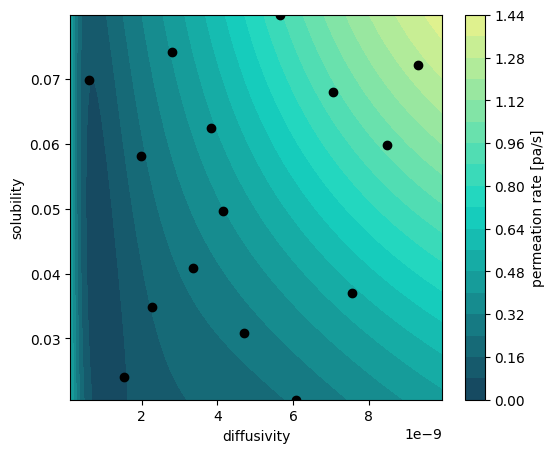

Text(0, 0.5, 'solubility')

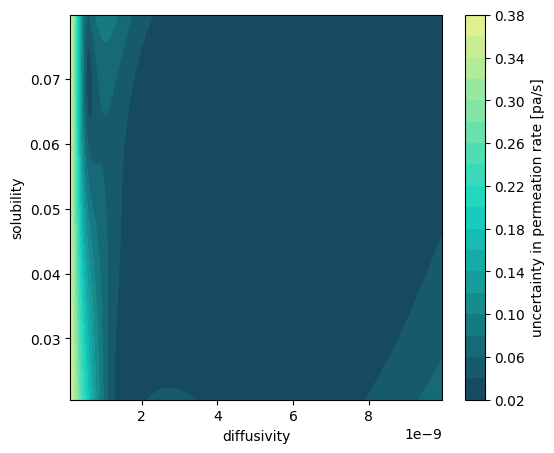

In [ ]:
# plot the outputs of the emulator
plt.figure(figsize=(6, 5))
colors = ["#16425B","#16D5C2","#EBF38B"]
custom_cmap = LinearSegmentedColormap.from_list("bah", colors)
#df_train = emulator.view_train_data()

# plot the tritium permeation rate
Z = np.array(df_pred["y"]).reshape(npoints,npoints)
plt.contourf(10**X, (Y), Z, levels=20, cmap=custom_cmap)  # filled contours
plt.colorbar(label="permeation rate [pa/s]")
plt.scatter(10**train_df["logdiffusivity"],train_df["solubility"],color="black")
plt.xlabel("diffusivity")
plt.ylabel("solubility")
plt.show()

# plot the error in tritium permeation rate
plt.figure(figsize=(6, 5))

Zerr = np.array(df_std["y"]).reshape(npoints,npoints)
plt.contourf(10**X, (Y), Zerr, levels=20, cmap=custom_cmap)  # filled contours
plt.colorbar(label="uncertainty in permeation rate [pa/s]")
plt.xlabel("diffusivity")
plt.ylabel("solubility")

In [ ]:
#Loading test data
# Save the y_csv string to a file
with open("test_x.csv", "w") as f:
    f.write(test_x)

#Need to upload relevant resources to UE
client.resources.upload(
    project_id=projects_dict["UoM"],
    name="test_x",
    file_path="/content/test_x.csv",
    resource_type="dataset"
)

'68f64e31a7ae95bc3bd10221'

In [ ]:
#Loading test data
# Save the y_csv string to a file
with open("test_y.csv", "w") as f:
    f.write(test_y)

#Need to upload relevant resources to UE
client.resources.upload(
    project_id=projects_dict["UoM"],
    name="test_y",
    file_path="/content/test_y.csv",
    resource_type="dataset"
)

'68f64e32a7ae95bc3bd10224'

In [ ]:
resources_dict = {resource.name: resource.id for resource in client.resources.list_resources(project_id=projects_dict["UoM"], resource_type="dataset")}
print(resources_dict)

{'train_x': '68f64e0ca7ae95bc3bd10218', 'train_y': '68f64e0da7ae95bc3bd1021b', 'df_grid_test': '68f64e0fa7ae95bc3bd1021e', 'test_x': '68f64e31a7ae95bc3bd10221', 'test_y': '68f64e32a7ae95bc3bd10224'}


In [ ]:
# Predict on test_X using the trained model
test_x_loader = Node(
    node_name="LoadDataset",
    label="Load test_x",
    project_id=projects_dict["UoM"],
    file_id=ResourceID(id=resources_dict["test_x"]).model_dump()
)
train_graph.add_node(test_x_loader)
testXhandle = test_x_loader.make_handle("file")

test_y_loader = Node(
    node_name="LoadDataset",
    label="Load test_y",
    project_id=projects_dict["UoM"],
    file_id=ResourceID(id=resources_dict["test_y"]).model_dump()
)
train_graph.add_node(test_y_loader)
test_y_handle = test_y_loader.make_handle("file")


In [ ]:
#Predicting on the test data
predict_test = Node(
    node_name="PredictModel",
    label="Predict on test_x",
    dataset=testXhandle,
    model=output_model,
    seed=42
)
train_graph.add_node(predict_test)

# Get prediction
output_predictions_test = predict_test.make_handle("prediction")
output_uncertainty_test = predict_test.make_handle("uncertainty")

In [ ]:
#Downloading the predictions and uncertainty.
download_test_predictions = Node(
    node_name="Download",
    label="Download Test Predictions",
    file=output_predictions_test
)
download_test_uncertainty = Node(
    node_name="Download",
    label="Download Test Uncertainty",
    file=output_uncertainty_test
)

# Add download nodes to the graph and connect them to the predict node
train_graph.add_node(download_test_predictions)
train_graph.add_node(download_test_uncertainty)

# Define the output handles for the download nodes
output_download_test_predictions = download_test_predictions.make_handle("file")
output_download_test_uncertainty = download_test_uncertainty.make_handle("file")

In [ ]:
#We need to now score the model, based on the true test data outputs
score_model = Node(
    node_name="ScoreModel",
    label="Score Model",
    predictions=output_predictions_test,
    truth=test_y_handle,
    metrics = ["MSE","RMSE","R2", "MSLL"],
    predictions_uncertainty = output_uncertainty_test,
    train_outputs = test_y_handle
)

train_graph.add_node(score_model)
output_score = score_model.make_handle("scores")

In [ ]:
# Display the scores
display_score = Node(
    node_name="Display",
    label="Display Score",
    value=output_score
)

train_graph.add_node(display_score)

In [ ]:
# Wrap the graph in a workflow node. This is overwriting the previous train workflow, adding all the nodes we created.
train_workflow = Workflow(
    graph=train_graph.nodes,
    inputs=train_graph.external_input,
    external_input_id=train_graph.external_input_id,
    requested_output={
        "Predictions": output_download_test_predictions.model_dump(),
        "Uncertainty": output_download_test_uncertainty.model_dump()
        }
    )

# Run the workflow
predict_response_test = client.run_node(train_workflow)
print(predict_response_test)

status=<JobStatus.COMPLETED: 'completed'> message='Job completed at 2025-10-20 14:59:41.219337' inputs={'graph': {'nodes': {'Load train_x': {'type': 'LoadDataset', 'inputs': {'project_id': {'node_name': '_', 'node_handle': 'Load train_x_project_id'}, 'file_id': {'node_name': '_', 'node_handle': 'Load train_x_file_id'}}}, 'Load train_y': {'type': 'LoadDataset', 'inputs': {'project_id': {'node_name': '_', 'node_handle': 'Load train_y_project_id'}, 'file_id': {'node_name': '_', 'node_handle': 'Load train_y_file_id'}}}, 'Model Config': {'type': 'ModelConfig', 'inputs': {}}, 'Train Model': {'type': 'TrainModel', 'inputs': {'config': {'node_name': 'Model Config', 'node_handle': 'config'}, 'inputs': {'node_name': 'Load train_x', 'node_handle': 'file'}, 'outputs': {'node_name': 'Load train_y', 'node_handle': 'file'}}}, 'Load test_X': {'type': 'LoadDataset', 'inputs': {'project_id': {'node_name': '_', 'node_handle': 'Load test_X_project_id'}, 'file_id': {'node_name': '_', 'node_handle': 'Load t

In [ ]:
# Download the predictions and save as a DataFrame
predictions_response_test = get_presigned_url(predict_response_test.outputs["outputs"]["Predictions"])
predictions_test_df = pd.read_csv(StringIO(predictions_response_test.text))  # Save the predictions to a DataFrame

# Download the uncertainty and save as a DataFrame
uncertainty_response_test = get_presigned_url(predict_response_test.outputs["outputs"]["Uncertainty"])
uncertainty_test_df = pd.read_csv(StringIO(uncertainty_response_test.text))  # Save the uncertainty to a DataFrame

In [ ]:
# Extract the scores CSV from the Score Model node in the workflow response
scores_csv = predict_response_test.progress["Score Model"].outputs["scores"]["csv"]
scores_df = pd.read_csv(StringIO(scores_csv))
print(scores_df)

MSLLscore = scores_df.loc[scores_df['metric_name'] == 'MSLL', 'score'].values[0]
R2score = scores_df.loc[scores_df['metric_name'] == 'R2', 'score'].values[0]

# stopping criterion for active learning loop
if MSLLscore < -1.5 and R2score>0.95:
    print("model is good")

  metric_name     score
0         MSE  0.046213
1        RMSE  0.214971
2          R2  0.407703
3        MSLL -1.968296


In [ ]:
# Create a validation plot, comparing predictions to true values for test data
ytrue = y_test.reset_index(drop=True).to_frame(name="y")
ypred = predictions_test_df.reset_index(drop=True)
yprederr = uncertainty_test_df.reset_index(drop=True)

print(ytrue)
print(ypred)
print(yprederr)

          y
0  0.477585
1  0.678230
2  0.009934
3  0.554342
4  0.839772
          y
0  0.493390
1  0.685438
2  0.490302
3  0.553319
4  0.837130
          y
0  0.041651
1  0.025604
2  0.356869
3  0.025207
4  0.041407


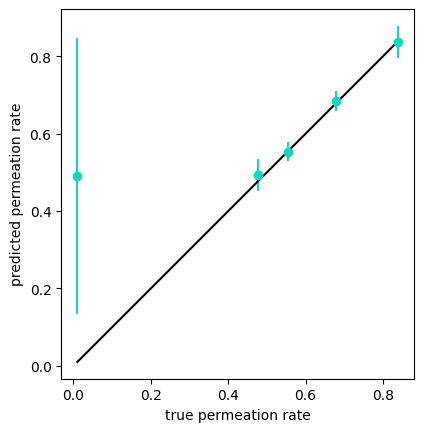

In [ ]:
# Plot predicted vs true values with error bars
fig, axs = plt.subplots(1, 1)
plt.errorbar(
    ytrue.squeeze(),           # or ytrue["y"].values
    ypred.squeeze(),           # or ypred.values.ravel()
    yerr=yprederr.squeeze(),   # or yprederr.values.ravel()
    linestyle="", marker="o", color="#16D5C2"
)
plt.plot(
    [np.min(ytrue), np.max(ytrue)],
    [np.min(ytrue), np.max(ytrue)],
    color="black"
)
plt.xlabel("true permeation rate")
plt.ylabel("predicted permeation rate")
axs.set_aspect("equal")

In [ ]:
for resource_id in resources_dict.values():
    client.resources.delete_resource(
        project_id=projects_dict["UoM"],
        resource_id=resource_id,
        resource_type="dataset",
    )